In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('data/AB_NYC_2019-Copy1.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
for column in df.columns:
    if df[column].dtypes == 'object':
        df[column] = df[column].str.lower().str.replace(' ', '_')

In [5]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,brooklyn,40.64749,-73.97237,private_room,149,1,9,0.21,6,365
1,manhattan,40.75362,-73.98377,entire_home/apt,225,1,45,0.38,2,355
2,manhattan,40.80902,-73.94190,private_room,150,3,0,0.00,1,365
3,brooklyn,40.68514,-73.95976,entire_home/apt,89,1,270,4.64,1,194
4,manhattan,40.79851,-73.94399,entire_home/apt,80,10,9,0.10,1,0


In [28]:
# df.price = np.log1p(df['price'])

In [6]:
df_full, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

In [8]:
del df_train['price']
del df_val['price']
del df_test['price']

In [9]:
dv = DictVectorizer(sparse=False)

In [10]:
dict_train = df_train.to_dict(orient='records')
X_train = dv.fit_transform(dict_train)

dict_val = df_val.to_dict(orient='records')
X_val = dv.transform(dict_val)

dict_test = df_test.to_dict(orient='records')
X_test = dv.transform(dict_test)

In [11]:
dtr = DecisionTreeRegressor(max_depth=1)

In [12]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
features = list(dv.get_feature_names_out())
print(export_text(dtr, feature_names=features))

|--- room_type=entire_home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=entire_home/apt >  0.50
|   |--- value: [5.15]



In [14]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_val)
# roc_auc_score(y_val, y_pred)
np.sqrt(mean_squared_error(y_val, y_pred))

0.546852866994087

In [15]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_val)
# roc_auc_score(y_val, y_pred)
np.sqrt(mean_squared_error(y_val, y_pred))
# mean_squared_error(y_val, y_pred)

0.46828408489138723

In [17]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

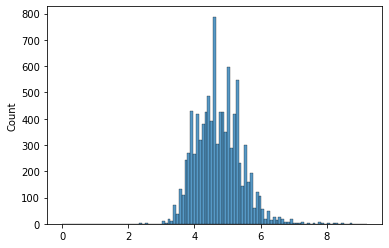

In [19]:
sns.histplot(y_val)

In [1]:
scores = []
for n in range (10, 201, 10) :
    rfr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=1)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_val)
    scores.append((n, np.sqrt(mean_squared_error(y_val, y_pred))))

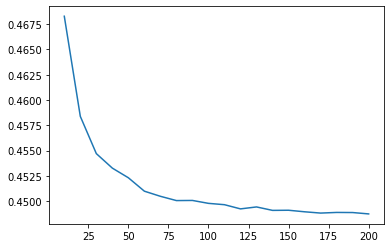

In [74]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [77]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range (10, 201, 10) :
        rfr = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=2)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        scores.append((n, d, np.sqrt(mean_squared_error(y_val, y_pred))))

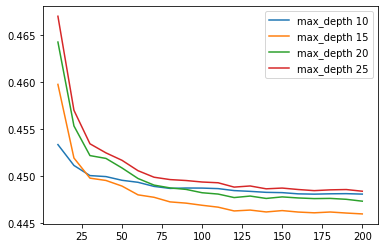

In [79]:
columns = ['n_estimators', 'max_depth', 'rmse']
df_scores = pd.DataFrame(scores, columns = columns)
for d in [10, 15, 20, 25]:
    df_sub = df_scores[df_scores.max_depth == d]
    plt.plot(df_sub.n_estimators, df_sub.rmse, label='max_depth %d' %d)
plt.legend()

In [94]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_val)
df_import = pd.DataFrame()
df_import['features'] = dv.get_feature_names_out()
df_import['importance'] = rfr.feature_importances_
df_import.sort_values(by='importance', ascending=False)

,features,importance
12,room_type=entire_home/apt,0.391898
3,longitude,0.154101
2,latitude,0.152775
0,availability_365,0.076264
11,reviews_per_month,0.054430
4,minimum_nights,0.053252
10,number_of_reviews,0.041594
7,neighbourhood_group=manhattan,0.034047
1,calculated_host_listings_count,0.030102
14,room_type=shared_room,0.005023


In [83]:
import xgboost as xgb

In [86]:
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val,feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [87]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [88]:
y_pred = model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

0.4428797483783348

In [89]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

0.4400906421582789

In [90]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

1.630620653662836